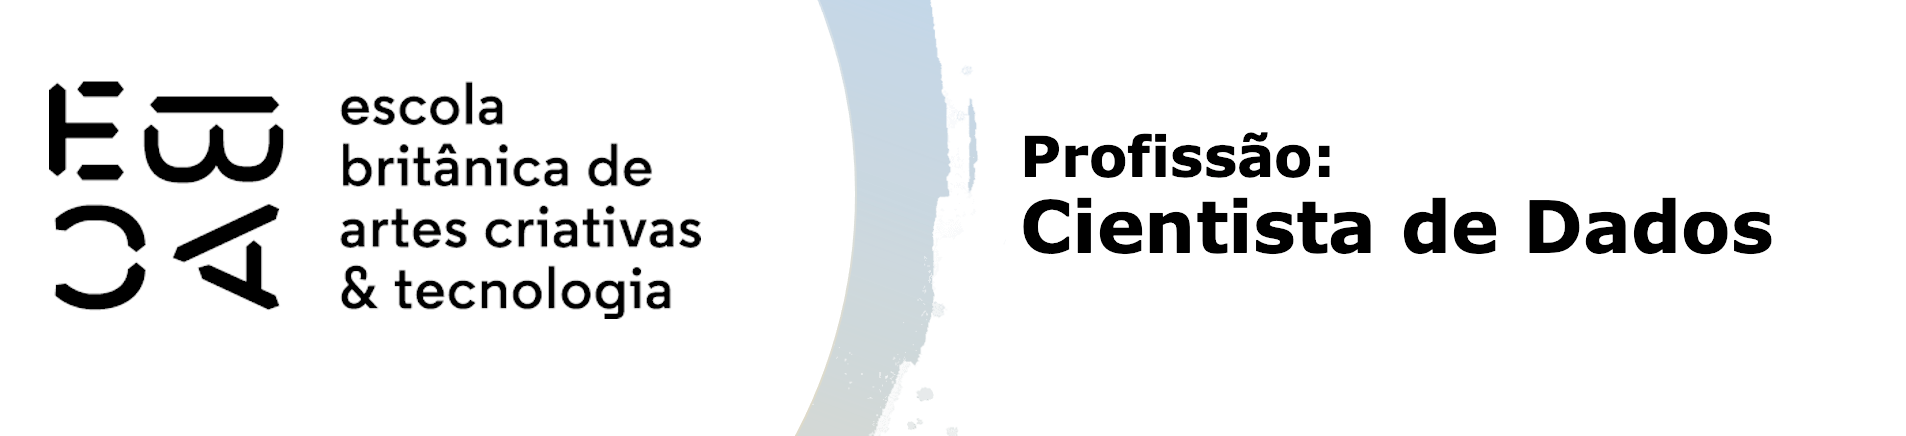

# Métodos hierárquicos de agrupamento - Tarefa

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc

## 1) Repetindo o que fizemos em aula

Primeiramente vamos repetir o que fizemos em aula com a base de pinguins.

1. Selecione as variáveis quantitativas da base de pinguins
2. Elimine valores faltantes
3. Padronize as variáveis para média zero e desvio padrão 1
4. Faça um agrupamento hierárquico dividindo essa base em 3 grupos
5. Faça o Dendrograma

In [3]:
peng = sns.load_dataset('penguins')
peng_num = peng.select_dtypes('number').dropna()

In [5]:
peng.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [7]:
peng_num.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


In [9]:
std = StandardScaler()
peng_std = std.fit_transform(peng_num)

In [11]:
clus_3 = AgglomerativeClustering(
    linkage = 'complete',
    distance_threshold = None,
    n_clusters=3
)
clus_3.fit(peng_std)

AgglomerativeClustering(linkage='complete', n_clusters=3)

In [13]:
peng_num['group'] = clus_3.labels_
peng_num['group'].value_counts()

group
1    165
0    123
2     54
Name: count, dtype: int64

In [15]:
peng = peng.join(peng_num['group'], how='left')

In [17]:
peng.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,group
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,1.0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,1.0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,1.0
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,1.0


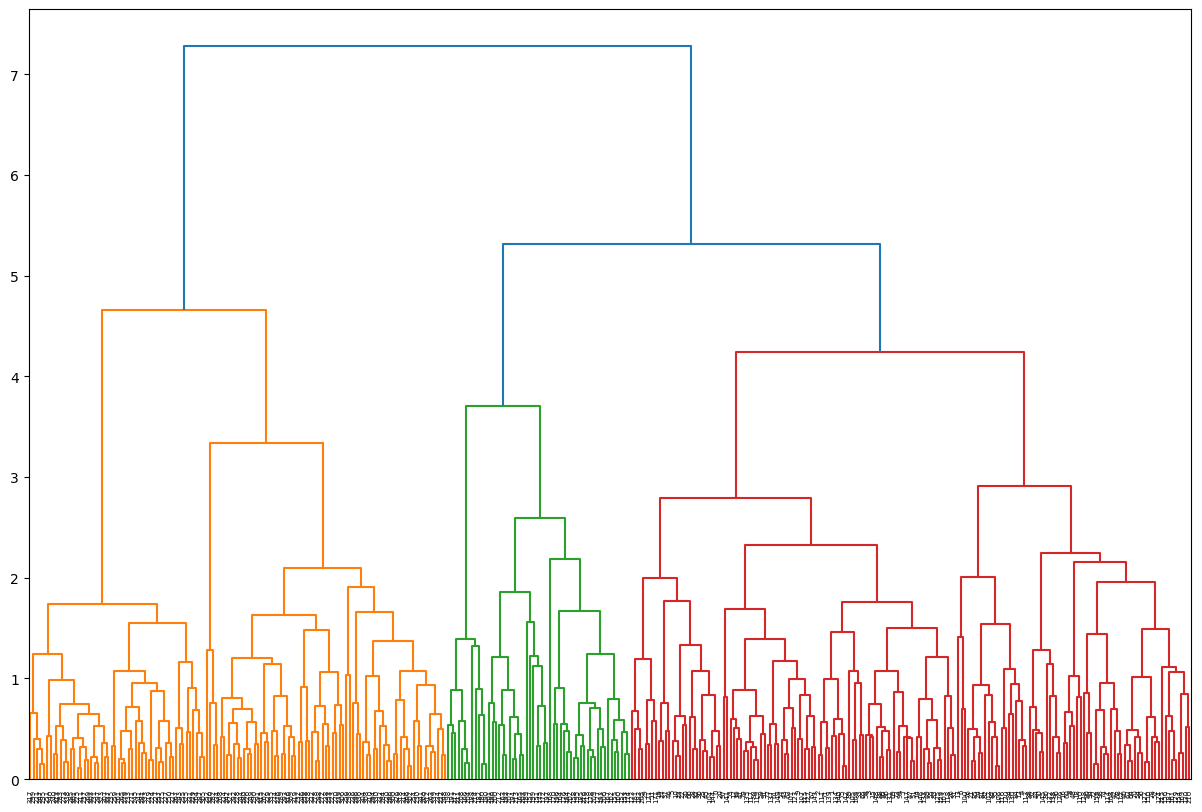

In [19]:
plt.figure(figsize=(15, 10))
dend = shc.dendrogram(shc.linkage(peng_std, method='complete'))

## 2) Avalie os grupos

Descreva os grupos:

- Quantos pinguins de cada espécie há em cada grupo?
- Descreva as variáveis quantitativas de cada grupo com as técnicas que você preferir.

In [21]:
pd.crosstab(peng['species'], peng['group'])

group,0.0,1.0,2.0
species,,,
Adelie,0,151,0
Chinstrap,0,14,54
Gentoo,123,0,0


In [23]:
def biplot(data, pca, groups, ax=None, var_names=None):
    coeff = pca.components_[0:2, :].T
    X = data[:, 0]
    Y = data[:, 1]
    n = coeff.shape[0]
    scalex = 2/(X.max() - X.min())
    scaley = 2/(Y.max() - Y.min())

    print(f'groups shape: {groups.shape}')

    if not ax:
        fig, ax = plt.subplots(figsize = (10, 10))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5, 
                 length_includes_head=True, head_width=0.1, head_length=0.1)
        if var_names is None:
            ax.text(coeff[i,0] * 1.1, coeff[i,1] * 1.1, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0] * 1.1, coeff[i,1] * 1.1, var_names[i], color = 'k', ha = 'center', va = 'center')

    sns.kdeplot(
        x = X*scalex, 
        y = Y*scaley, 
        hue=groups, ax=ax, 
        fill=True, 
        alpha=.6, 
        #bw_adjust=.2,
        palette='viridis',
        #thresh=0.02
    )

    ax.set_xlabel(f"PC0, {pca.explained_variance_ratio_[0] * 100:.3f}% da variância explicada")
    ax.set_ylabel(f"PC1, {pca.explained_variance_ratio_[1] * 100:.3f}% da variância explicada")
   
    ax.grid()

    return ax

In [25]:
pca = PCA()
peng_pca = pca.fit_transform(peng_num.iloc[:, :4])

groups shape: (342,)


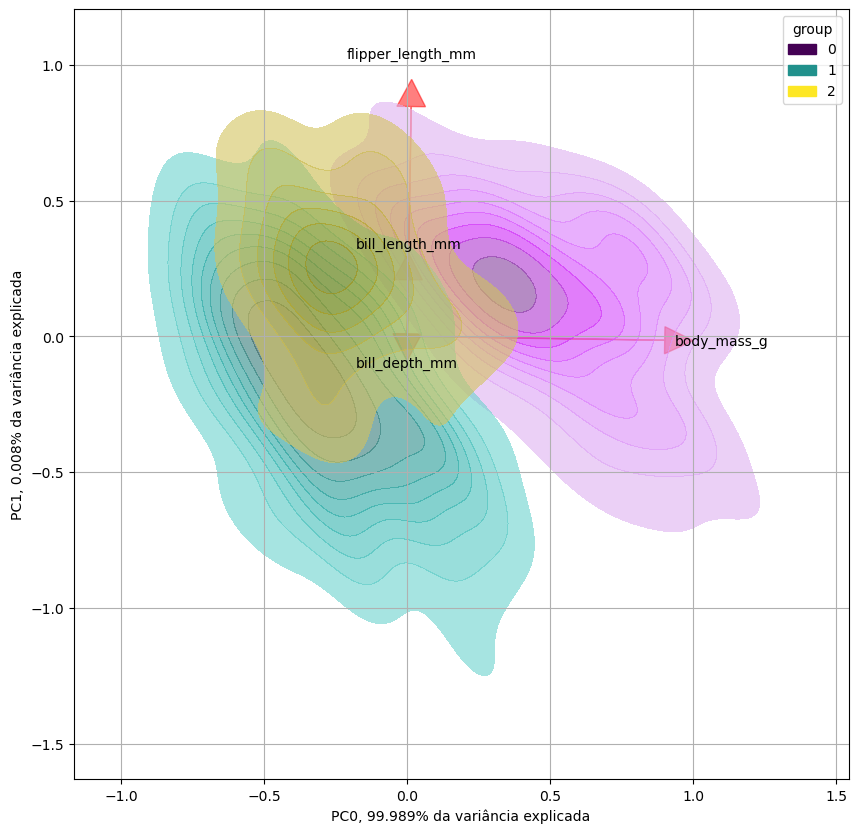

In [27]:
biplot(peng_pca, pca, peng_num['group'], var_names=peng_num.columns[0:4]);

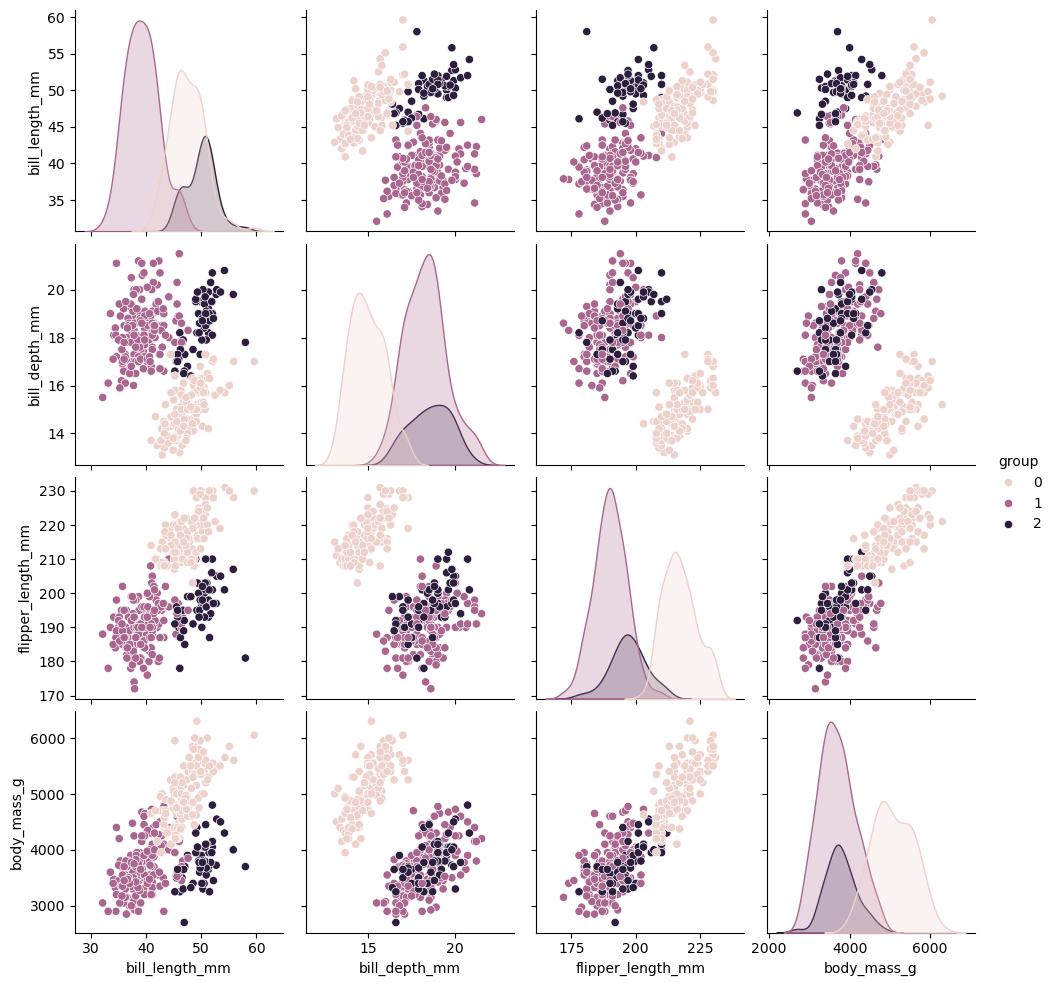

In [31]:
sns.pairplot(data=peng_num, hue='group');

## 3) Alterando o agrupamento

O Dendrogarma sugere que podemem haver grupos interessantes se solicitarmos mais que 3 grupos. Se quisermos testar o agrupamento com mais de 3 grupos, quantos grupos o Dendrograma te sugere? (Dica: não faça mais que 6 grupos).

- Faça o agrupamento hierárquico semelhante ao anterior, mas com o número de grupos que você escolheu.
- Analise esses agrupamentos
    - Quantos pinguins de cada espécie há em cada grupo?
    - Quantos pinguins de cada espécie machos e fêmeas há em cada grupo?
- Na sua opinião, o agrupamento capturou algum padrão natural dos dados? Qual?

In [33]:
clus_5 = AgglomerativeClustering(
    linkage = 'complete',
    distance_threshold = None,
    n_clusters=5
)
clus_5.fit(peng_std)

AgglomerativeClustering(linkage='complete', n_clusters=5)

In [35]:
clus_6 = AgglomerativeClustering(
    linkage = 'complete',
    distance_threshold = None,
    n_clusters=6
)
clus_6.fit(peng_std)

AgglomerativeClustering(linkage='complete', n_clusters=6)

In [37]:
groups_5 = pd.Series(clus_5.labels_, name='group_5')
peng = peng.join(groups_5, how='left')
groups_6 = pd.Series(clus_6.labels_, name='group_6')
peng = peng.join(groups_6, how='left')

In [39]:
peng.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,group,group_5,group_6
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,1.0,4.0,1.0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,1.0,4.0,1.0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,1.0,4.0,1.0
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,1.0,2.0,2.0


In [41]:
peng['sex_species'] = peng['sex'] + ' ' + peng['species']

In [43]:
tab_5 = pd.crosstab(peng['sex_species'], peng['group_5'])
tab_5 = tab_5 / tab_5.sum()
tab_5

group_5,0.0,1.0,2.0,3.0,4.0
sex_species,,,,,
Female Adelie,0.000000,0.000000,0.750000,0.000000,0.241758
Female Chinstrap,0.574074,0.000000,0.029412,0.019231,0.000000
Female Gentoo,0.000000,0.757576,0.000000,0.134615,0.000000
Male Adelie,0.018519,0.000000,0.117647,0.000000,0.703297
Male Chinstrap,0.407407,0.000000,0.102941,0.000000,0.054945
Male Gentoo,0.000000,0.242424,0.000000,0.846154,0.000000


In [45]:
tab_6 = pd.crosstab(peng['sex_species'], peng['group_6'])
tab_6 = tab_6 / tab_6.sum()
tab_6

group_6,0.0,1.0,2.0,3.0,4.0,5.0
sex_species,,,,,,
Female Adelie,0.000000,0.241758,0.750000,0.000000,0.00000,0.000000
Female Chinstrap,0.000000,0.000000,0.029412,0.019231,0.50000,0.833333
Female Gentoo,0.757576,0.000000,0.000000,0.134615,0.00000,0.000000
Male Adelie,0.000000,0.703297,0.117647,0.000000,0.02381,0.000000
Male Chinstrap,0.000000,0.054945,0.102941,0.000000,0.47619,0.166667
Male Gentoo,0.242424,0.000000,0.000000,0.846154,0.00000,0.000000


Acredito que o melhor agrupamento é o com 6 grupos mas, como é difícil diferenciar Chinstraps machos de fêmeas, o agrupamento com 5 grupos acabou ficando melhor.